# Car Price Prediction

In [142]:
#Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk


## Data Import and Preliminary Exploration

The first step is combining multiple csv files into a single df. This was due to the bugs of the AutoTrader Scraper, which caused it to stall during the progress, hence resulting in different files.

In [143]:
#Load CSV
df = pd.read_csv('kijijiGTA.csv')
print(df.shape)
#Load second CSV
df_part2 = pd.read_csv('kijiji_car02.csv')
df_part2 = df_part2.iloc[:,1:]
print(df_part2.shape)
#Load third and fourth CSV
df_part3 = pd.read_csv('kijiji_car03.csv')
df_part3 = df_part3.iloc[:,1:]
print(df_part3.shape)
df_part4 = pd.read_csv('kijiji_car04.csv')
df_part4 = df_part4.iloc[:,1:]
print(df_part4.shape)

(4004, 14)
(777, 14)
(290, 14)
(725, 14)


In [144]:
df = pd.concat([df,df_part2,df_part3,df_part4],ignore_index=True)
print(df.shape)
df

(5796, 14)


,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
0,Chevrolet,Silverado 1500,2019,"$30,999.99",Black,LT,Used,Pickup Truck,4 x 4,Automatic,Gasoline,"115,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Brydon Drive, Etobicoke, ON\"
1,Volkswagen,Tiguan,2015,"$11,450.00",Grey,COMFORTLINE 4WD,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Gasoline,"129,000",https://www.carproof.com/order?ref=kijiji&vin=...,"1205 Finch Avenue West, Toronto, ON, M3J 2E8\"
2,GMC,Acadia,2019,"$33,988.00",Other,SLT-2,Used,Other,All-wheel drive (AWD),Automatic,Gasoline,"73,893",https://reports.carproof.com/en/main?id=ioaVnM...,"1900 Victoria Park Avenue, Toronto, ON, M1R 1T6\"
3,Acura,TL,2004,$500.00,na,na,Used,Sedan,na,na,na,"200,500",https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M5N1A1\"
4,Honda,Accord,2017,"$15,499.00",White,LX,Used,Sedan,Front-wheel drive (FWD),Other,Gasoline,"93,000",https://www.carproof.com/order?ref=kijiji&vin=...,"1726 Kingston Road, Scarborough, ON, M1N 1S8\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,BMW,X1,2022,"$51,949",White,XDrive28i,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,na,na,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5792,na,na,na,na,na,na,na,na,na,na,na,na,na,na
5793,na,na,na,na,na,na,na,na,na,na,na,na,na,na
5794,na,na,na,na,na,na,na,na,na,na,na,na,na,na


In [145]:
columns = df.columns.tolist()
numerical_features = ['model_year','list_price','mileage']
categorical_features = list(set(columns) - set(numerical_features))
categorical_features.reverse()
print("Categorical Features:",categorical_features)
print("Numerical Features:",numerical_features)

Categorical Features: ['carfax_link', 'body_type', 'wheel_config', 'transmission', 'color', 'condition', 'model', 'configuration', 'brand', 'fuel_type', 'dealer_address']
Numerical Features: ['model_year', 'list_price', 'mileage']


## Data Cleaning

The main goals of the data cleaning process are:
- Convert price and mileage to appropriate numerical types
- Dealing with NaN and 'na' entries
- Find outliers
- Remove unwanted features

By printing out the number of unique values for each column, we can have a rough idea as to what preprocessing is required:
- Car model has too many unique values to do one-hot encoding later. Furthermore, if the model sees unseen entries for model, the performance may be poor.
- Configuration also has too many unique values. We either have to extract more generalized information from configuration, or the column has to be removed all together.
- Same with the carfax link as well as the dealer's address.

In [146]:
#Print out the number of unique values
print("DATASET HAS",df.shape[0],"ENTRIES")
for i in columns:
    print(i,"has",len(df[i].unique()),"unique values")

DATASET HAS 5796 ENTRIES
brand has 42 unique values
model has 264 unique values
model_year has 47 unique values
list_price has 966 unique values
color has 18 unique values
configuration has 988 unique values
condition has 5 unique values
body_type has 10 unique values
wheel_config has 6 unique values
transmission has 5 unique values
fuel_type has 5 unique values
mileage has 1034 unique values
carfax_link has 1003 unique values
dealer_address has 325 unique values


Below I just printed some of the unique values for selected categorical features with minimal unique values. Something to note: both transmission and fuel type both have 'na' as well as 'other'. I will later see if 'na' can be combined with 'other'.

In [147]:
print('brand',df['brand'].unique())
print('color',df['color'].unique())
print('condition',df['condition'].unique())
print('transmission',df['transmission'].unique())
print('fuel_type',df['fuel_type'].unique())

brand ['Chevrolet' 'Volkswagen' 'GMC' 'Acura' 'Honda' 'Pontiac' 'Chrysler'
 'Porsche' 'Toyota' 'Ford' 'Cadillac' 'BMW' 'Tesla' 'Audi' 'Hyundai'
 'Mercedes-Benz' 'Infiniti' 'Mazda' 'Jeep' 'Maserati' 'Nissan' 'Dodge'
 'Kia' 'Buick' 'Other' 'Jaguar' 'MINI' 'Lexus' 'Ram' 'Subaru' 'Land Rover'
 'Fiat' 'Genesis' 'Mitsubishi' 'Suzuki' 'Saturn' 'Lincoln' 'Isuzu' 'Volvo'
 'na' 'alfaromeo' 'Ferrari']
color ['Black' 'Grey' 'Other' 'na' 'White' 'Silver' 'Blue' 'Burgundy' 'Red'
 'Brown' 'Beige' 'Gold' 'Green' 'Yellow' 'Orange' 'Tan' 'Purple'
 'Off-White']
condition ['Used' 'New' 'Lease Takeover' 'na' 'Salvage']
transmission ['Automatic' 'na' 'Other' 'Manual' '0']
fuel_type ['Gasoline' 'na' 'Hybrid-Electric' 'Diesel' 'Other']


I see how many entries are actually missing. Out of all of the variables, the only column that has "missing" or "NaN" values is mileage.

In [148]:
df.isnull().sum()

brand               0
model               0
model_year          0
list_price          0
color               0
configuration       0
condition           0
body_type           0
wheel_config        0
transmission        0
fuel_type           0
mileage           107
carfax_link         0
dealer_address      0
dtype: int64

Below is count of the occurrences of 'na' in each column. This will have to be dealt with for each column.

In [149]:
df.isin(['na']).sum(axis=0)

brand              483
model              488
model_year         483
list_price         786
color              786
configuration     1219
condition          483
body_type          483
wheel_config       879
transmission       669
fuel_type         2356
mileage            736
carfax_link       1237
dealer_address     483
dtype: int64

### Remove entries with ambiguous Brand and Model attributes

In [150]:
df = df[df['brand']!='Other']

### Remove Duplicates

In [151]:
df[df.duplicated()].sort_values("list_price")

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
315,Ford,F-150,2020,"$1,000.00",na,na,Used,Pickup Truck,na,na,na,88,https://www.carproof.com/order?ref=kijiji&vin=...,"549 King Street East, Toronto, ON\"
99,Cadillac,DeVille,2003,"$1,000.00",Burgundy,DHS,Used,Sedan,Front-wheel drive (FWD),Automatic,Gasoline,"200,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Woodbridge, ON L4L 8L6\"
112,Cadillac,DeVille,2003,"$1,000.00",Burgundy,DHS,Used,Sedan,Front-wheel drive (FWD),Automatic,Gasoline,"200,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Woodbridge, ON L4L 8L6\"
74,Cadillac,DeVille,2003,"$1,000.00",Burgundy,DHS,Used,Sedan,Front-wheel drive (FWD),Automatic,Gasoline,"200,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Woodbridge, ON L4L 8L6\"
125,Cadillac,DeVille,2003,"$1,000.00",Burgundy,DHS,Used,Sedan,Front-wheel drive (FWD),Automatic,Gasoline,"200,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Woodbridge, ON L4L 8L6\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4663,na,na,na,na,na,na,na,na,na,na,na,na,na,na
4671,na,na,na,na,na,na,na,na,na,na,na,na,na,na
4675,Honda,Civic,2012,na,na,ex,Used,Sedan,Front-wheel drive (FWD),Manual,na,"190,000",na,"Toronto, ON M5V"
325,Toyota,Venza,2014,na,Other,na,Used,"SUV, Crossover",Other,Automatic,na,"122,203",https://www.carproof.com/order?ref=kijiji&vin=...,"4249 Kingston Road, Scarborough, ON, M1E 2M5\"


In [152]:
print("With duplicates:",len(df))
df = df.drop_duplicates()
print("No duplicates:",len(df))

With duplicates: 5734
No duplicates: 1394


In [153]:
df[df.duplicated()].sort_values("list_price")

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address


### Numerical Variables
First, I deal with the numerical values.

While 3 variables should be numeric, none of them are actually so.

In [154]:
df._get_numeric_data().columns

Index([], dtype='object')

#### Price

I decided to remove all of the rows with missing prices. Firstly, price is the "target" variable and secondly, the majority of the data is non-missing.

In [155]:
df = df[df['list_price'] != 'na']

The data type is also casted to a float type with the dollar sign and comma removed.

In [156]:
# float(df['list_price'][0][1:].replace(',',''))
df['list_price'] = df['list_price'].apply(lambda x:float(x[1:].replace(',','')))

From the stats of list price, we can see a minimum price of $1.00. This is probably a fake ad or mis-listing so we can remove it. There are some others with low prices but they are either older vehicles or lease take-overs (we will deal with them later on).

In [157]:
df.sort_values('list_price')

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
615,BMW,3-Series,2006,1.0,Grey,Zhp,Used,Sedan,Rear-wheel drive (RWD),Automatic,Gasoline,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"Gormley, ON L4E\"
490,BMW,M3,2008,1.0,Blue,M Zhp,Used,Coupe (2 door),Rear-wheel drive (RWD),Manual,Gasoline,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"Gormley, ON L4E\"
2781,Honda,Other,2011,150.0,na,EX,Used,Coupe (2 door),Front-wheel drive (FWD),Automatic,Gasoline,"1,000",https://www.carproof.com/order?ref=kijiji&vin=...,"1000 Rowntree Dairy Rd, Woodbridge, ON L4L 5V8..."
526,Volkswagen,Jetta,2019,287.0,Black,comfortline,Lease Takeover,Sedan,Front-wheel drive (FWD),Automatic,Gasoline,"63,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Thornhill, ON L4J 4P8\"
3916,Chevrolet,Sonic,2022,298.0,White,LT,Lease Takeover,Hatchback,Front-wheel drive (FWD),Automatic,na,"20,800",https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M1P5E4\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,Porsche,Panamera,2019,149800.0,White,"GTS Sport Turismo,AWD,PREMIUM PKG+,SPORT CHRONO,",Used,Sedan,All-wheel drive (AWD),Automatic,Other,"25,592",https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
5030,Ferrari,Other,2005,159800.0,Silver,"Spider, 4.3L V8 483HP,RWD ,FABSPEED EXHAUST,BR...",Used,Convertible,Rear-wheel drive (RWD),Automatic,Other,"50,957",https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
4578,Mercedes-Benz,E-Class,2020,159800.0,White,"AMG E63 S, 603 HP, CARBON FIBER PKG, NAV, PANO",Used,Wagon,All-wheel drive (AWD),Automatic,Other,"11,000",https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
5671,Land Rover,Range Rover,2019,169800.0,Black,"Autobiography LWB, MASSAGE SEATS, NAV, HEATED ...",Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,"48,985",https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"


In [158]:
df = df[df['list_price'] > 1.0]

In [159]:
df.head()

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
0,Chevrolet,Silverado 1500,2019,30999.99,Black,LT,Used,Pickup Truck,4 x 4,Automatic,Gasoline,"115,000",https://www.carproof.com/order?ref=kijiji&vin=...,"Brydon Drive, Etobicoke, ON\"
1,Volkswagen,Tiguan,2015,11450.00,Grey,COMFORTLINE 4WD,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Gasoline,"129,000",https://www.carproof.com/order?ref=kijiji&vin=...,"1205 Finch Avenue West, Toronto, ON, M3J 2E8\"
2,GMC,Acadia,2019,33988.00,Other,SLT-2,Used,Other,All-wheel drive (AWD),Automatic,Gasoline,"73,893",https://reports.carproof.com/en/main?id=ioaVnM...,"1900 Victoria Park Avenue, Toronto, ON, M1R 1T6\"
3,Acura,TL,2004,500.00,na,na,Used,Sedan,na,na,na,"200,500",https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M5N1A1\"
4,Honda,Accord,2017,15499.00,White,LX,Used,Sedan,Front-wheel drive (FWD),Other,Gasoline,"93,000",https://www.carproof.com/order?ref=kijiji&vin=...,"1726 Kingston Road, Scarborough, ON, M1N 1S8\"


#### Model Year

In [160]:
df['model_year'] = df['model_year'].apply(lambda x:int(x))

#### Mileage

Now I deal with the mileage variable. First deal with all of the "na" and NaN entries.

For the "na" entries, alot the entries are "new cars".

In [161]:
df[df['mileage']== 'na']

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
151,Hyundai,Santa Fe,2021,36535.0,Black,Preferred,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,na,na,na,"5515 Ambler Drive, Mississauga, ON, L4W 4N3\"
179,Nissan,Other,2021,31354.0,Other,SV,New,"Minivan, Van",Front-wheel drive (FWD),Other,na,na,na,"275 West Hunt Club Road, Ottawa, ON, K2E 1A6\"
231,Nissan,Rogue,2021,33411.0,White,SV,New,"SUV, Crossover",Front-wheel drive (FWD),Other,na,na,na,"275 West Hunt Club Road, Ottawa, ON, K2E 1A6\"
249,Dodge,Grand Caravan,2021,34735.0,Red,SXT,New,"Minivan, Van",Front-wheel drive (FWD),Automatic,na,na,na,"935 Woodlawn Road West, Guelph, ON, N1K 1B7\"
352,Hyundai,Santa Fe,2020,50828.0,Other,Ultimate 6 Passenger,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,na,na,na,"785 Woodlawn Road West, Guelph, ON, N1K 1E9\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,BMW,X1,2022,53479.0,Grey,XDrive28i M Sport Edition,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,na,na,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5745,BMW,3-Series,2022,61829.0,White,XDrive Sedan (5R79),New,Sedan,All-wheel drive (AWD),Automatic,Other,na,na,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5746,BMW,X1,2022,51949.0,White,XDrive28i,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,na,na,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5747,BMW,X3,2022,65449.0,Grey,XDrive30i,New,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,na,na,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"


For mileage, all of the cars with 'na' are new cars (total na mileage == new cars with na mileage). Therefore, 'na' can be replaced with a low mileage number.

In [162]:
print("All cars with na mileage:",len(df[df['mileage']== 'na']))
print("New cars with na mileage:",len(df[(df['mileage']== 'na') & (df['condition']== 'New')]))

All cars with na mileage: 110
New cars with na mileage: 110


In [163]:
df["mileage"].replace({"na": "50"}, inplace=True)

There are only 10 NaN entries, which is not a lot. Furthermore, the list price doesn't show a specific trend for NaN entries. We can remove them.

In [164]:
nan_mileage = df[df['mileage'].isnull()]
print(len(nan_mileage))
nan_mileage.describe()

8


,model_year,list_price
count,8.000000,8.000000
mean,2016.000000,23358.000000
std,5.237229,13516.439535
min,2008.000000,1800.000000
25%,2011.500000,14248.000000
50%,2018.000000,25492.500000
75%,2020.250000,33271.250000
max,2021.000000,39990.000000


For cars that have NaN mileage and older than 2010, all but one have a list price of $1. We can remove this as this is either a fake add or a mis-listing.

In [165]:
nan_mileage

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
129,Mercedes-Benz,Other,2010,15999.0,White,WWW.MOLANDSONS.CA,Used,Other,Other,Automatic,Diesel,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"1897 Wilson Avenue, North York, ON, M9M 1A2\"
584,Toyota,RAV4,2012,8995.0,Other,na,Used,Sedan,All-wheel drive (AWD),Automatic,na,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"North York, ON M3J 3K2\"
1893,Toyota,RAV4,2020,37100.0,White,Hybrid SE | Low KMS,Used,"SUV, Crossover",Other,Automatic,Gasoline,NaN,https://reports.carproof.com/en/main?id=ulJfKR...,"1897 Eglinton Avenue East, Toronto, ON, M1L 2L6\"
1989,Isuzu,Other,2017,39990.0,White,20' Box P.T. Gate,Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Gasoline,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"5298 Highway 7, Woodbridge, ON, L4L 1T3\"
2897,Chevrolet,Express,2019,26990.0,White,"3/4 Ton EXTENDED Cargo Van, Loaded",Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Gasoline,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"5298 Highway 7, Woodbridge, ON, L4L 1T3\"
3149,Pontiac,Pursuit,2008,1800.0,Black,2dr Cpe GT,Used,Coupe (2 door),Front-wheel drive (FWD),Manual,na,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"5404 Gateway Blvd, Edmonton, AB, T6H 1B7\"
3330,Ram,1500,2021,31995.0,Other,**BRAND NEW** RE-DESIGNED!! TRADESMAN 5.7L,Used,Pickup Truck,Other,Automatic,na,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"212 Lakeshore Road West, Mississauga, ON, L5H ..."
3527,Jeep,Cherokee,2021,23995.0,Other,"**BRAND NEW!!** That's Right! Only $23,995!",Used,"SUV, Crossover",Front-wheel drive (FWD),Automatic,na,NaN,https://www.carproof.com/order?ref=kijiji&vin=...,"212 Lakeshore Road West, Mississauga, ON, L5H ..."


In [166]:
df = df[df['mileage'].isnull() == False]

In [167]:
df['mileage'] = df['mileage'].apply(lambda x:int(x.replace(',','')))

In [168]:
#Print out the number of unique values
print("DATASET HAS",df.shape[0],"ENTRIES")
for i in columns:
	print(i,"has",len(df[i].unique()),"unique values")

DATASET HAS 1355 ENTRIES
brand has 39 unique values
model has 259 unique values
model_year has 25 unique values
list_price has 833 unique values
color has 18 unique values
configuration has 966 unique values
condition has 4 unique values
body_type has 9 unique values
wheel_config has 6 unique values
transmission has 5 unique values
fuel_type has 5 unique values
mileage has 1013 unique values
carfax_link has 984 unique values
dealer_address has 308 unique values


### Categorical Variables
Now I will deal with the categorical features that require data cleaning. I will deal with brand, model, and carfax link in the next section as they need feature engineering.

In [169]:
df

,brand,model,model_year,list_price,color,configuration,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
0,Chevrolet,Silverado 1500,2019,30999.99,Black,LT,Used,Pickup Truck,4 x 4,Automatic,Gasoline,115000,https://www.carproof.com/order?ref=kijiji&vin=...,"Brydon Drive, Etobicoke, ON\"
1,Volkswagen,Tiguan,2015,11450.00,Grey,COMFORTLINE 4WD,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Gasoline,129000,https://www.carproof.com/order?ref=kijiji&vin=...,"1205 Finch Avenue West, Toronto, ON, M3J 2E8\"
2,GMC,Acadia,2019,33988.00,Other,SLT-2,Used,Other,All-wheel drive (AWD),Automatic,Gasoline,73893,https://reports.carproof.com/en/main?id=ioaVnM...,"1900 Victoria Park Avenue, Toronto, ON, M1R 1T6\"
3,Acura,TL,2004,500.00,na,na,Used,Sedan,na,na,na,200500,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M5N1A1\"
4,Honda,Accord,2017,15499.00,White,LX,Used,Sedan,Front-wheel drive (FWD),Other,Gasoline,93000,https://www.carproof.com/order?ref=kijiji&vin=...,"1726 Kingston Road, Scarborough, ON, M1N 1S8\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,Toyota,Corolla,2016,15998.00,Black,CE,Used,Sedan,Front-wheel drive (FWD),Automatic,Other,131540,https://www.carproof.com/order?ref=kijiji&vin=...,"2333 Barton Street East, Hamilton, ON, L8E 2W8"
5756,Mercedes-Benz,CLA,2016,39800.00,Black,"AMG CLA45, 375HP, PANO, NAV, ACTIVE PARK",Used,Sedan,All-wheel drive (AWD),Automatic,Other,64372,https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
5757,Mercedes-Benz,GLE,2020,79995.00,Grey,GLE450|4MATIC|AMGPKG|HUD|NAV|BURMESTER|360CAM|...,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,43313,na,"100 Toro Road, North York, ON, M3J 2A9"
5758,BMW,3-Series,2012,15500.00,Blue,328i,Used,Sedan,Rear-wheel drive (RWD),Automatic,Gasoline,165000,https://www.carproof.com/order?ref=kijiji&vin=...,"North York, ON M3H 2V6"


#### Color

In [170]:
df['color'].value_counts()

Black        366
White        326
Grey         208
Blue         114
Silver       100
Red           79
Other         70
na            24
Brown         17
Gold          10
Burgundy       9
Beige          8
Green          8
Yellow         8
Orange         5
Tan            1
Purple         1
Off-White      1
Name: color, dtype: int64

In [171]:
df.loc[(df.color.isin(["Black","White","Grey","Blue","Silver","Red"]) == False), "color"] = "other"

#### Configuration
Configuration for each vehicle is unique and more importantly, does not have a standardized format. Some of them do have valuable "generalizable" information like "PREMIUM PKG" or "FULLY LOADED", however there are a lot of entries like "328i xDrive" which is a car model, or LXE which is trim level specific to that particular model. Therefore, including this column may lead to over-fitting.


In [172]:
df['configuration'].unique()

array(['LT', 'COMFORTLINE  4WD', 'SLT-2', 'na', 'LX', 'LIMITED',
       'LTLEATHER|NAVI|PANOROOF|',
       'SE, $62/wk, heated seat, alloys, backup camera', 'DHS',
       '1 OWNER, Accident Free, Navi, Heated Seats, AWD', 'LE',
       '320I X DRIVE SPORT+ NAVI PKG AUT0 SUNROOF 103K',
       'Autopilot, 21Whls, Sunroof, INSANE Mode, EV', 'LE AWD',
       'EX-T w/Honda Sensing/SUNROOF/REAR CAMERA !!!',
       'TOURING NAVIGATION LEATHER SUNROOF BACK UP CAMERA',
       'LIKE NEW!!/CHRISTMAS SPECIAL!!',
       'GTS/NAV/PORSCHE ENTRY&DRIVE/LANE CHANGE ASSIST',
       '3.0T QUATTRO PREM, N',
       'X DRIVE 35i M SPORT + ACTIVITY + PREMIUM PKG', 'sedan',
       '2.0L TRENDLINE 5 SPEED A/C H/SEATS REAR CAMERA 67K',
       '535d xDrive, NAVI, M', 'GLS SUNROOF ALLOYS BACK UP CAMERA',
       'S550', '1.8 TSI HIGHLINE NAVIGATION LEATHER SUNROOF',
       'Sport  | Sunroof | Rear Camera | Heated Seats',
       'EX-AUTO-SUNROOF-CAMERA-ONLY 85KM', 'Limited Edition',
       'GX MODEL, SKYACTIV', 'LUXU

In [173]:
df = df.drop(columns=['configuration'])

#### Condition
Condition seems to be acceptable. There are no missing values.

In [174]:
df['condition'].unique()
df.loc[df.condition == 'salvage', "condition"] = 'Used'

#### Body Type
Body type also seems to be reasonable, there are no overlaps in types.

In [175]:
df['body_type'].unique()

array(['Pickup Truck', 'SUV, Crossover', 'Other', 'Sedan',
       'Coupe (2 door)', 'Convertible', 'Minivan, Van', 'Hatchback',
       'Wagon'], dtype=object)

#### Wheel Config.

In [176]:
df['wheel_config'].unique()

array(['4 x 4', 'All-wheel drive (AWD)', 'na', 'Front-wheel drive (FWD)',
       'Other', 'Rear-wheel drive (RWD)'], dtype=object)

In [177]:
df[df['wheel_config'] == 'na'].describe()

,model_year,list_price,mileage
count,31.00000,31.000000,31.000000
mean,2010.16129,7451.870968,159820.064516
std,6.20267,5349.342930,129805.877741
min,1986.00000,400.000000,88.000000
25%,2008.00000,3450.000000,77500.000000
50%,2011.00000,6500.000000,147000.000000
75%,2014.50000,12000.000000,207500.000000
max,2020.00000,18000.000000,496000.000000


In [178]:
df[df['wheel_config'] == 'Other']

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
11,Ford,Escape,2017,15988.0,White,Used,"SUV, Crossover",Other,Automatic,Gasoline,74899,https://www.carproof.com/order?ref=kijiji&vin=...,"4700 Sheppard Avenue East, Toronto, ON, M1S 3V6\"
28,Honda,Other,2008,1190.0,Red,Used,Sedan,Other,Other,Gasoline,513,https://www.carproof.com/order?ref=kijiji&vin=...,"4 Harvest Street, Lindsay, ON, K9V 4W9\"
40,Toyota,Yaris,2010,4995.0,Blue,Used,Sedan,Other,Automatic,Gasoline,140373,https://www.carproof.com/order?ref=kijiji&vin=...,"1037 Belfast Road, Ottawa, ON, K1B 3S2\"
113,Jeep,Cherokee,2016,17950.0,Grey,Used,"SUV, Crossover",Other,Automatic,Gasoline,116000,https://www.carproof.com/order?ref=kijiji&vin=...,"1205 Finch Avenue West, Toronto, ON, M3J 2E8\"
183,Honda,Fit,2015,11350.0,Black,Used,Hatchback,Other,Automatic,na,90713,https://www.carproof.com/order?ref=kijiji&vin=...,"1897 Wilson Avenue, North York, ON, M9M 1A2\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5489,Ford,Bronco,2021,41388.0,other,Used,"SUV, Crossover",Other,Automatic,Other,75,https://www.carproof.com/order?ref=kijiji&vin=...,"79 East Don Roadway, Toronto, ON, M4M 2A5"
5579,BMW,3-Series,2021,57900.0,Black,Used,Sedan,Other,Automatic,Other,12847,https://www.carproof.com/order?ref=kijiji&vin=...,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5622,BMW,3-Series,2020,51900.0,White,Used,Sedan,Other,Automatic,Other,21798,https://www.carproof.com/order?ref=kijiji&vin=...,"11 Sunlight Park Road, Toronto, ON, M4M 1B5"
5647,Ford,Bronco,2021,42269.0,other,Used,"SUV, Crossover",Other,Automatic,Other,7000,https://www.carproof.com/order?ref=kijiji&vin=...,"940 Kingston Road, Pickering, ON, L1V 1B3"


In [179]:
df["wheel_config"].replace({"na": "Unknown","Other": "Unknown"}, inplace=True)

#### Transmission

In [180]:
df['transmission'].unique()

array(['Automatic', 'na', 'Other', 'Manual', '0'], dtype=object)

In [181]:
df[df['transmission']=='0']

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
4903,Ford,Mustang,2020,139777.0,Blue,Used,Coupe (2 door),Rear-wheel drive (RWD),0,Gasoline,19800,https://www.carproof.com/order?ref=kijiji&vin=...,"1323 Kennedy Road, Scarborough, ON, M1P 2L6"
5357,Chevrolet,Camaro,2019,32999.0,Red,Used,Coupe (2 door),Rear-wheel drive (RWD),0,Gasoline,32991,https://www.carproof.com/order?ref=kijiji&vin=...,"715 Kingston Road, Pickering, ON, L1V 1A9"


In [182]:
df["transmission"].replace({"0": "Automatic"}, inplace=True)

In [183]:
df[df['transmission']=='na']

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
3,Acura,TL,2004,500.0,other,Used,Sedan,Unknown,na,na,200500,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M5N1A1\"
142,Ford,F-150,2020,1000.0,other,Used,Pickup Truck,Unknown,na,na,88,https://www.carproof.com/order?ref=kijiji&vin=...,"549 King Street East, Toronto, ON\"
1386,Chevrolet,Colorado,2007,3500.0,Red,Used,Pickup Truck,Unknown,na,na,400000,https://www.carproof.com/order?ref=kijiji&vin=...,"North York, ON M9M 2E2\"
1577,Ford,Windstar,2003,400.0,other,Used,"Minivan, Van",Front-wheel drive (FWD),na,na,350000,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M9L2Y7\"
2879,Mercedes-Benz,S-Class,1997,500.0,Black,Used,Sedan,Rear-wheel drive (RWD),na,Gasoline,200000,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M3J3P7\"
3046,Nissan,Rogue,2015,6500.0,other,Used,"SUV, Crossover",Unknown,na,na,156000,https://www.carproof.com/order?ref=kijiji&vin=...,"Midland Ave, Toronto, ON M1P 3B7, Canada\"
3620,GMC,Sierra,2007,2000.0,other,Used,Pickup Truck,Unknown,na,na,290400,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M6B1C8\"
3634,Dodge,Caravan,2003,500.0,other,Used,"Minivan, Van",Unknown,na,na,456000,https://www.carproof.com/order?ref=kijiji&vin=...,"275 Poyntz Ave, Toronto, ON M2N 1J8, Canada\"
3636,Acura,TL,2006,1600.0,other,Used,Sedan,Front-wheel drive (FWD),na,Gasoline,294500,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M1B1Y6\"
3723,Acura,EL,2004,400.0,other,Used,Sedan,Unknown,na,na,496000,https://www.carproof.com/order?ref=kijiji&vin=...,"275 Poyntz Ave, Toronto, ON M2N 1J8, Canada\"


In [184]:
df["transmission"].replace({"Other": "Automatic","na": "Automatic"}, inplace=True)

In [185]:
df.loc[df.brand == "Tesla", "transmission"] = "Electric"

In [186]:
df['transmission'].unique()

array(['Automatic', 'Electric', 'Manual'], dtype=object)

Check again when dealing with fuel type.

#### Fuel Type

In [187]:
df['fuel_type'].value_counts()

Gasoline           662
na                 366
Other              282
Diesel              32
Hybrid-Electric     13
Name: fuel_type, dtype: int64

In [188]:
df[df['fuel_type']=='na']

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
3,Acura,TL,2004,500.0,other,Used,Sedan,Unknown,Automatic,na,200500,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M5N1A1\"
7,Chevrolet,Malibu,2019,19999.0,Blue,Used,Sedan,Front-wheel drive (FWD),Automatic,na,41432,https://www.carproof.com/order?ref=kijiji&vin=...,"2701 Derry Rd. E, Mississauga, ON, L4T 1A2\"
10,Toyota,Corolla,2008,2600.0,other,Used,Sedan,Unknown,Automatic,na,226,https://www.carproof.com/order?ref=kijiji&vin=...,"Toronto, ON M4B2E5\"
17,Toyota,RAV4,2016,15950.0,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,na,131000,https://reports.carproof.com/en/main?id=DCWc4i...,"1205 Finch Avenue West, Toronto, ON, M3J 2E8\"
18,Honda,Civic,2018,21877.0,White,Used,Coupe (2 door),Front-wheel drive (FWD),Automatic,na,30345,https://www.carproof.com/order?ref=kijiji&vin=...,"2685 Highway 7 West, Concord, ON, L4K 1V8\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,Hyundai,Elantra,2015,13000.0,Blue,Used,Hatchback,Unknown,Automatic,na,79000,na,"Toronto, ON M6E1L6"
4790,Hyundai,Elantra,2015,13000.0,Blue,Used,Hatchback,Unknown,Automatic,na,79000,na,"Toronto, ON M6E1L6"
5077,Honda,Civic,2012,9800.0,Black,Used,Coupe (2 door),Front-wheel drive (FWD),Manual,na,260,na,"Markham, ON L3R"
5079,Nissan,Pathfinder,2014,12000.0,Grey,Used,"SUV, Crossover",Unknown,Automatic,na,350000,na,"Toronto, ON M4B1A5"


In [189]:
df[df['fuel_type']=='Other']

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,fuel_type,mileage,carfax_link,dealer_address
2053,Ford,Other,2015,18995.0,Blue,Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Other,68000,https://www.carproof.com/order?ref=kijiji&vin=...,"1065 Martingrove Road, Etobicoke, ON, M9W 4W6\"
2113,Ford,F-150,2020,38398.0,Blue,New,Pickup Truck,4 x 4,Automatic,Other,50,na,"4700 Sheppard Avenue East, Toronto, ON, M1S 3V6\"
2876,Ford,Other,2012,12995.0,Red,Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Other,113000,https://www.carproof.com/order?ref=kijiji&vin=...,"1065 Martingrove Road, Etobicoke, ON, M9W 4W6\"
2924,Ford,Other,2014,19995.0,Blue,Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Other,24000,https://www.carproof.com/order?ref=kijiji&vin=...,"1065 Martingrove Road, Etobicoke, ON, M9W 4W6\"
2994,Ford,Other,2014,14495.0,White,Used,"Minivan, Van",Rear-wheel drive (RWD),Automatic,Other,129000,https://www.carproof.com/order?ref=kijiji&vin=...,"1065 Martingrove Road, Etobicoke, ON, M9W 4W6\"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,Porsche,Macan,2019,66800.0,Blue,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,20255,https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
5755,Toyota,Corolla,2016,15998.0,Black,Used,Sedan,Front-wheel drive (FWD),Automatic,Other,131540,https://www.carproof.com/order?ref=kijiji&vin=...,"2333 Barton Street East, Hamilton, ON, L8E 2W8"
5756,Mercedes-Benz,CLA,2016,39800.0,Black,Used,Sedan,All-wheel drive (AWD),Automatic,Other,64372,https://www.carproof.com/order?ref=kijiji&vin=...,"60 Martin Ross Avenue, Toronto, ON, M3J 2L4"
5757,Mercedes-Benz,GLE,2020,79995.0,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,Other,43313,na,"100 Toro Road, North York, ON, M3J 2A9"


In [190]:
# df.loc[df.brand == "Tesla", "fuel_type"] = "Hybrid-Electric"
# df.loc[df.model == "Optima Hybrid", "fuel_type"] = "Hybrid-Electric"

In [191]:
# df["fuel_type"].replace({"na": "Unspecified"}, inplace=True)
# df["fuel_type"].replace({"Other": "Unspecified"}, inplace=True)

In [192]:
df = df.drop(columns=['fuel_type'])

#### Carfax Link

In [193]:
df['carfax_link'].value_counts()

na                                                                                         208
https://www.carproof.com/order?ref=kijiji&vin=null                                         149
https://www.carproof.com/order?ref=kijiji&vin=WP1AA2A53KLB03369                              2
https://www.carproof.com/order?ref=kijiji&vin=3PCAJ5M39LF104592                              2
https://www.carproof.com/order?ref=kijiji&vin=1FTNE2EW4CDA30440                              2
                                                                                          ... 
https://www.carproof.com/order?ref=kijiji&vin=WBAFR9C55BC270268                              1
https://www.carproof.com/order?ref=kijiji&vin=SALVR2BG4FH007926                              1
https://www.carproof.com/order?ref=kijiji&vin=5XYKT3A26BG153917                              1
https://reports.carproof.com/en/main?id=D38DItsr3YD8ps9R0hNb/CbF/coWy4A9&utm_ref=kijiji      1
https://www.carproof.com/order?ref=kijiji&vin=WBA3

In [194]:
df.loc[df.condition == "New", "carfax_link"] = "New_Car"
df.loc[df.carfax_link.str.contains("null"), "carfax_link"] = "None"
df.loc[(df.carfax_link != "New_Car") & (df.carfax_link != "None"), "carfax_link"] = "Available"

#### Dealer Address

In [195]:
df['dealer_address'].value_counts()

60 Martin Ross Avenue, Toronto, ON, M3J 2L4\        87
1205 Finch Avenue West, Toronto, ON, M3J 2E8\       83
1235 Finch Ave. W., Toronto, ON, M3J 2G4\           74
60 Martin Ross Avenue, Toronto, ON, M3J 2L4         60
11 Sunlight Park Road, Toronto, ON, M4M 1B5         58
                                                    ..
North York, ON M9L 2W3\                              1
1897 Eglinton Avenue East, Toronto, ON, M1L 2L6\     1
Toronto, ON M6K\                                     1
50 Benson Court, Port Hope, ON, L1A 3V6\             1
North York, ON M3H 2V6                               1
Name: dealer_address, Length: 308, dtype: int64

In [196]:
df.loc[df.dealer_address.str.contains("Toronto|Etobicoke|East York|North York|Scarborough|York",case = False), "dealer_address"] = "Toronto"
df.loc[df.dealer_address.str.contains("Mississauga|Brampton|Markham|Vaugh|Richmond|Oakville",case = False), "dealer_address"] = "other_GTA"
df.loc[(df.dealer_address.isin(["Toronto","other_GTA"]) == False), "dealer_address"] = "other"

In [197]:
df['dealer_address'].value_counts()

Toronto      1045
other         167
other_GTA     143
Name: dealer_address, dtype: int64

In [198]:
df

,brand,model,model_year,list_price,color,condition,body_type,wheel_config,transmission,mileage,carfax_link,dealer_address
0,Chevrolet,Silverado 1500,2019,30999.99,Black,Used,Pickup Truck,4 x 4,Automatic,115000,Available,Toronto
1,Volkswagen,Tiguan,2015,11450.00,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,129000,None,Toronto
2,GMC,Acadia,2019,33988.00,other,Used,Other,All-wheel drive (AWD),Automatic,73893,Available,Toronto
3,Acura,TL,2004,500.00,other,Used,Sedan,Unknown,Automatic,200500,None,Toronto
4,Honda,Accord,2017,15499.00,White,Used,Sedan,Front-wheel drive (FWD),Automatic,93000,Available,Toronto
...,...,...,...,...,...,...,...,...,...,...,...,...
5755,Toyota,Corolla,2016,15998.00,Black,Used,Sedan,Front-wheel drive (FWD),Automatic,131540,Available,other
5756,Mercedes-Benz,CLA,2016,39800.00,Black,Used,Sedan,All-wheel drive (AWD),Automatic,64372,Available,Toronto
5757,Mercedes-Benz,GLE,2020,79995.00,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,43313,Available,Toronto
5758,BMW,3-Series,2012,15500.00,Blue,Used,Sedan,Rear-wheel drive (RWD),Automatic,165000,Available,Toronto


## Data Engineering

Car 'model' has too many unique values for the number of samples are in the dataset. Using one-hot encoding would create 259 columns. Deleting them, however, would remove crucial information as the model of a car is a significant factor of the price.

Therefore, I need another way to distinguish how much the vehicle is supposed cost when new. There are several options:
- Find a way to retrieve the MSRP for all of the samples. This did not work out because I could not find an appropriate (free) API. Furthermore, vehicle MSRP can vary between different markets, making the values unstable if I gather the data from different sources.
- Only use the brand of the vehicle. This is the simplest option however different models and trims can vary in price by a lot. For example the cheapest Tesla is under CAD 50,000 however the most expensive is around CAD 200,000.
- Using performance specification. Typically, the more cylinders, the higher the cost of a car. Furthermore, unlike MSRP, this does not vary often from country to country allow me to have more datasets at my disposal. This should give our model a good relative idea of how much the vehicle should have costed when purchased.

### Cylinders

In [199]:
#Print out the number of unique values
print("DATASET HAS",df.shape[0],"ENTRIES")
for i in df.columns:
	print(i,"has",len(df[i].unique()),"unique values")

DATASET HAS 1355 ENTRIES
brand has 39 unique values
model has 259 unique values
model_year has 25 unique values
list_price has 833 unique values
color has 7 unique values
condition has 4 unique values
body_type has 9 unique values
wheel_config has 5 unique values
transmission has 3 unique values
mileage has 1013 unique values
carfax_link has 3 unique values
dealer_address has 3 unique values


In [200]:
df2 = pd.read_csv('vehicles.csv')

In [201]:
specs_df = df2
specs_df = specs_df[(specs_df['model'].notna()) & (specs_df['cylinders'].notna())]
specs_df['model'].unique()

array(['sierra 1500 crew cab slt', 'silverado 1500',
       'silverado 1500 crew', ..., 'gand wagoneer', '96 Suburban',
       'Paige Glenbrook Touring'], dtype=object)

In [202]:
import re
# Standardize the model names

df['model'] = df['model'].apply(lambda x:re.sub('[^A-Za-z0-9]+', '', x.lower()))
specs_df['model'] = specs_df['model'].apply(lambda x:re.sub('[^A-Za-z0-9]+', '', x.lower()))

/var/folders/c9/k18251qn43qdyt5wnrczs_yw0000gp/T/ipykernel_79717/3221794032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_df['model'] = specs_df['model'].apply(lambda x:re.sub('[^A-Za-z0-9]+', '', x.lower()))


In [203]:
specs_df['cylinders'].value_counts()

6 cylinders     93536
4 cylinders     77252
8 cylinders     70697
5 cylinders      1694
10 cylinders     1424
other            1140
3 cylinders       651
12 cylinders      205
Name: cylinders, dtype: int64

In [204]:
specs_df['cylinders'].replace({"other": "0"}, inplace=True)
specs_df = specs_df[specs_df['cylinders']!= '0']
specs_df['cylinders'] = specs_df['cylinders'].apply(lambda x:int(x[0]))

/var/folders/c9/k18251qn43qdyt5wnrczs_yw0000gp/T/ipykernel_79717/67802142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specs_df['cylinders'].replace({"other": "0"}, inplace=True)


In [205]:
def findCylinder(bd,md,yr):
	try:
		try:
			results = specs_df[(specs_df.manufacturer.str.contains(bd,case = False)) & (specs_df.model.str.contains(md,case = False)) &  (specs_df['year'] <= yr) & (specs_df['year'] >= (yr-5))]
			cyldr = list(results['cylinders'].mode())[0]
		except:
			results = specs_df[(specs_df.manufacturer.str.contains(bd,case = False)) &  (specs_df['year'] <= yr) & (specs_df['year'] >= (yr-5))]
			cyldr = list(results['cylinders'].mode())[0]
	except:
		cyldr = 4
	return cyldr

In [206]:
df['brand']

0           Chevrolet
1          Volkswagen
2                 GMC
3               Acura
4               Honda
            ...      
5755           Toyota
5756    Mercedes-Benz
5757    Mercedes-Benz
5758              BMW
5760              BMW
Name: brand, Length: 1355, dtype: object

In [207]:
df['cylinders'] = df.loc[:,:].apply(lambda x:findCylinder(x['brand'],x['model'],x['model_year']), axis = 1)
df = df.drop(columns=['model'])

In [219]:
df.loc[df.transmission == 'Electric', "cylinders"] = 0

In [220]:
df

,brand,list_price,color,condition,body_type,wheel_config,transmission,mileage,carfax_link,dealer_address,cylinders,vehicle_age
0,Chevrolet,30999.99,Black,Used,Pickup Truck,4 x 4,Automatic,115000,Available,Toronto,8,3
1,Volkswagen,11450.00,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,129000,None,Toronto,4,7
2,GMC,33988.00,other,Used,Other,All-wheel drive (AWD),Automatic,73893,Available,Toronto,6,3
3,Acura,500.00,other,Used,Sedan,Unknown,Automatic,200500,None,Toronto,6,18
4,Honda,15499.00,White,Used,Sedan,Front-wheel drive (FWD),Automatic,93000,Available,Toronto,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
5755,Toyota,15998.00,Black,Used,Sedan,Front-wheel drive (FWD),Automatic,131540,Available,other,4,6
5756,Mercedes-Benz,39800.00,Black,Used,Sedan,All-wheel drive (AWD),Automatic,64372,Available,Toronto,6,6
5757,Mercedes-Benz,79995.00,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,43313,Available,Toronto,6,2
5758,BMW,15500.00,Blue,Used,Sedan,Rear-wheel drive (RWD),Automatic,165000,Available,Toronto,6,10


### Year

In [221]:
df['current_year'] = 2022
df['vehicle_age'] = df['current_year'] - df['model_year']
df = df.drop(columns=['model_year','current_year'])

KeyError: 'model_year'

In [222]:
cols = list(df.columns)
print(cols)
df = df[cols[0:1]+cols[2:]+[cols[1]]]

['brand', 'list_price', 'color', 'condition', 'body_type', 'wheel_config', 'transmission', 'mileage', 'carfax_link', 'dealer_address', 'cylinders', 'vehicle_age', 'current_year']


### Generalizing the Brands


In [223]:
list(df.brand.unique())
american = ['Chevrolet','GMC','Pontiac','Chrysler','Ford','Cadillac','Tesla','Jeep','Ram','Lincoln','Saturn','Dodge','Buick']
german = ['Volkswagen','BMW','Porsche','Audi','Mercedes-Benz','MINI']
japanese = ['Acura','Honda','Toyota','Mazda','Nissan','Lexus','Subaru','Mitsubishi','Suzuki','Infiniti']
korean = ['Hyundai','Kia','Genesis']
british = ['Jaguar','Land Rover'],
italian = ['Ferrari','Fiat','alfaromeo','Maserati']

In [224]:
df.loc[df.brand.isin(american ), "brand"] = "american"
df.loc[df.brand.isin(german), "brand"] = "german"
df.loc[df.brand.isin(japanese), "brand"] = "japanese"
df.loc[df.brand.isin(korean), "brand"] = "korean"
df.loc[df.brand.isin(['Jaguar','Land Rover']), "brand"] = "british"
df.loc[df.brand.isin(italian), "brand"] = "italian"
df.loc[df.brand == "Volvo", "brand"] = "other"
df.brand.value_counts()
df.to_csv('cleanedDF.csv',index=False)

### Outliers

In [357]:
df = pd.read_csv('cleanedDF.csv')

In [358]:
from scipy import stats
z_scores = stats.zscore(df['list_price'])
abs_z_scores = np.abs(z_scores)
df['list_price_z_scores'] = abs_z_scores

In [359]:
df_no_outlier = df[df['list_price_z_scores']<=3]
df_no_outlier = df_no_outlier.drop(columns=['list_price_z_scores'])

In [360]:
df_no_outlier.to_csv('cleanedDF_no_outliers.csv',index=False)
df_no_outlier

,brand,color,condition,body_type,wheel_config,transmission,mileage,carfax_link,dealer_address,cylinders,vehicle_age,list_price
0,american,Black,Used,Pickup Truck,4 x 4,Automatic,115000,Available,Toronto,8,3,30999.99
1,german,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,129000,None,Toronto,4,7,11450.00
2,american,other,Used,Other,All-wheel drive (AWD),Automatic,73893,Available,Toronto,6,3,33988.00
3,japanese,other,Used,Sedan,Unknown,Automatic,200500,None,Toronto,6,18,500.00
4,japanese,White,Used,Sedan,Front-wheel drive (FWD),Automatic,93000,Available,Toronto,4,5,15499.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1350,japanese,Black,Used,Sedan,Front-wheel drive (FWD),Automatic,131540,Available,other,4,6,15998.00
1351,german,Black,Used,Sedan,All-wheel drive (AWD),Automatic,64372,Available,Toronto,6,6,39800.00
1352,german,Grey,Used,"SUV, Crossover",All-wheel drive (AWD),Automatic,43313,Available,Toronto,6,2,79995.00
1353,german,Blue,Used,Sedan,Rear-wheel drive (RWD),Automatic,165000,Available,Toronto,6,10,15500.00


## Using Cleaned Data

In [378]:
df_cleaned = pd.read_csv('cleanedDF_no_outliers.csv')
df_cleaned.columns

Index(['brand', 'color', 'condition', 'body_type', 'wheel_config',
       'transmission', 'mileage', 'carfax_link', 'dealer_address', 'cylinders',
       'vehicle_age', 'list_price'],
      dtype='object')

In [379]:
df_oh = pd.get_dummies(df_cleaned,drop_first=True)
print(len(df_oh.columns))
df_oh.columns

37


Index(['mileage', 'cylinders', 'vehicle_age', 'list_price', 'brand_british',
       'brand_german', 'brand_italian', 'brand_japanese', 'brand_korean',
       'brand_other', 'color_Blue', 'color_Grey', 'color_Red', 'color_Silver',
       'color_White', 'color_other', 'condition_New', 'condition_Salvage',
       'condition_Used', 'body_type_Coupe (2 door)', 'body_type_Hatchback',
       'body_type_Minivan, Van', 'body_type_Other', 'body_type_Pickup Truck',
       'body_type_SUV, Crossover', 'body_type_Sedan', 'body_type_Wagon',
       'wheel_config_All-wheel drive (AWD)',
       'wheel_config_Front-wheel drive (FWD)',
       'wheel_config_Rear-wheel drive (RWD)', 'wheel_config_Unknown',
       'transmission_Electric', 'transmission_Manual', 'carfax_link_New_Car',
       'carfax_link_None', 'dealer_address_other', 'dealer_address_other_GTA'],
      dtype='object')

### Distribution

<AxesSubplot:xlabel='list_price', ylabel='Density'>

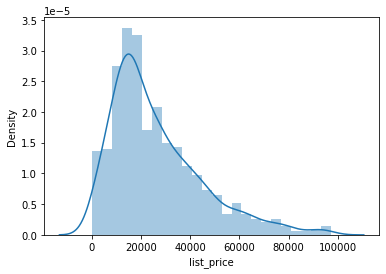

In [380]:
sns.distplot(df_oh.list_price)

In [381]:
df_oh.list_price = np.log(df_oh.list_price)
df_oh.mileage = np.log(df_oh.mileage)

### Correlation

In [382]:
list(df_oh.columns)

['mileage',
 'cylinders',
 'vehicle_age',
 'list_price',
 'brand_british',
 'brand_german',
 'brand_italian',
 'brand_japanese',
 'brand_korean',
 'brand_other',
 'color_Blue',
 'color_Grey',
 'color_Red',
 'color_Silver',
 'color_White',
 'color_other',
 'condition_New',
 'condition_Salvage',
 'condition_Used',
 'body_type_Coupe (2 door)',
 'body_type_Hatchback',
 'body_type_Minivan, Van',
 'body_type_Other',
 'body_type_Pickup Truck',
 'body_type_SUV, Crossover',
 'body_type_Sedan',
 'body_type_Wagon',
 'wheel_config_All-wheel drive (AWD)',
 'wheel_config_Front-wheel drive (FWD)',
 'wheel_config_Rear-wheel drive (RWD)',
 'wheel_config_Unknown',
 'transmission_Electric',
 'transmission_Manual',
 'carfax_link_New_Car',
 'carfax_link_None',
 'dealer_address_other',
 'dealer_address_other_GTA']

In [383]:
cols = list(df_oh.columns)
df_oh = df_oh[cols[0:3]+cols[4:]+[cols[3]]]

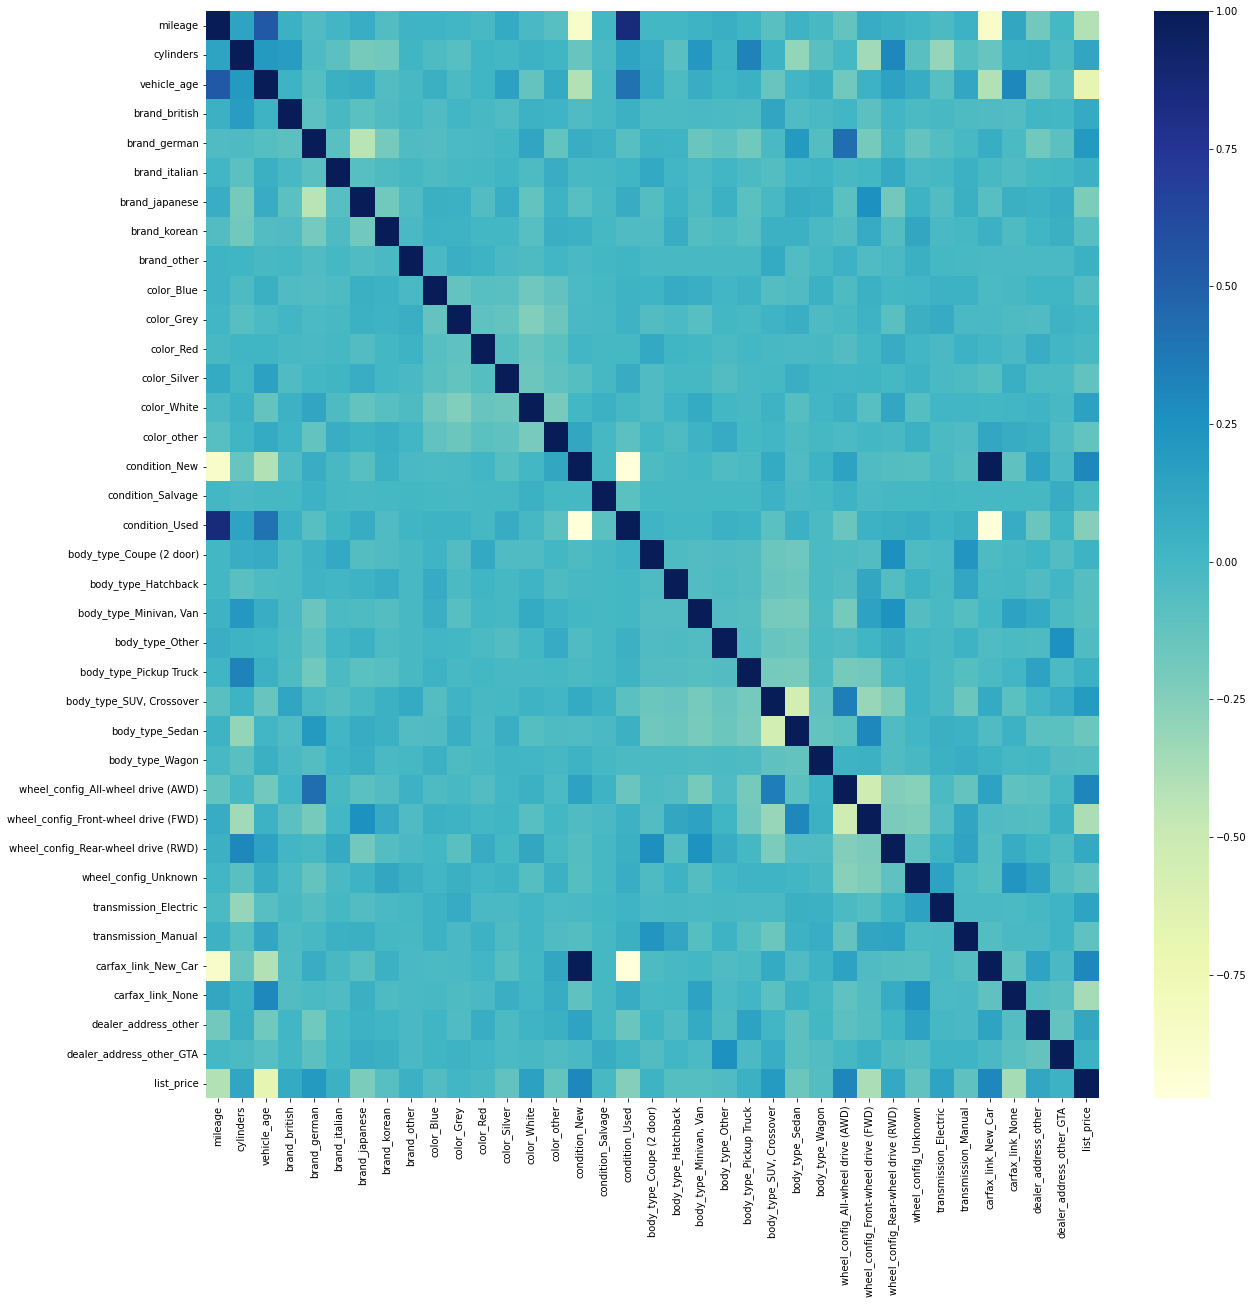

In [384]:
corrmat = df_oh.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g=sns.heatmap(df_oh[top_corr_features].corr(),annot=False,cmap="YlGnBu")

In [385]:
df_oh = df_oh.drop(columns=['carfax_link_New_Car'])
df_oh.head()

,mileage,cylinders,vehicle_age,brand_british,brand_german,brand_italian,brand_japanese,brand_korean,brand_other,color_Blue,...,wheel_config_All-wheel drive (AWD),wheel_config_Front-wheel drive (FWD),wheel_config_Rear-wheel drive (RWD),wheel_config_Unknown,transmission_Electric,transmission_Manual,carfax_link_None,dealer_address_other,dealer_address_other_GTA,list_price
0,11.652687,8,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.341742
1,11.767568,4,7,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,9.345745
2,11.210373,6,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,10.433763
3,12.208570,6,18,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,6.214608
4,11.440355,4,5,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,9.648531


In [387]:
X = df_oh.iloc[:,:-1]
y = df_oh.iloc[:,-1]
X.iloc[4]

mileage                                 11.440355
cylinders                                4.000000
vehicle_age                              5.000000
brand_british                            0.000000
brand_german                             0.000000
brand_italian                            0.000000
brand_japanese                           1.000000
brand_korean                             0.000000
brand_other                              0.000000
color_Blue                               0.000000
color_Grey                               0.000000
color_Red                                0.000000
color_Silver                             0.000000
color_White                              1.000000
color_other                              0.000000
condition_New                            0.000000
condition_Salvage                        0.000000
condition_Used                           1.000000
body_type_Coupe (2 door)                 0.000000
body_type_Hatchback                      0.000000


In [388]:
### Feature Importance
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

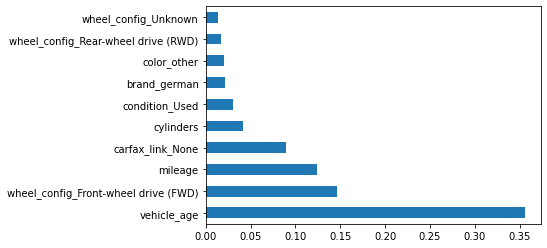

In [389]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [390]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Linear Regression

In [477]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import joblib

s=StandardScaler()
X_train_S = s.fit_transform(X_train)
linearRegression = LinearRegression().fit(X_train_S, y_train)
X_test_S=s.transform(X_test)
y_pred=linearRegression.predict(X_test_S)
y_test = y_test.reset_index(drop=True)
y_pred = y_pred

In [478]:
outThingLR = pd.concat([y_test, pd.Series(y_pred),np.exp(y_test), np.exp(pd.Series(y_pred))],ignore_index = True,axis=1)
outThingLR

,0,1,2,3
0,8.410721,9.264493,4495.0,10556.458009
1,10.377016,10.307631,32113.0,29960.390735
2,10.470731,10.642835,35268.0,41891.381325
3,9.453287,9.750535,12750.0,17163.414346
4,10.668676,10.335507,42988.0,30807.286690
...,...,...,...,...
327,10.562354,10.440885,38652.0,34230.926333
328,8.699181,8.805979,5998.0,6674.027430
329,10.428216,10.305243,33800.0,29888.913709
330,11.179046,11.041800,71614.0,62429.915711


In [479]:
from sklearn import metrics
import pickle
# open a file, where you ant to store the data
file = open('linearRegression.pkl', 'wb')
# dump information to that file
pickle.dump(linearRegression, file)
joblib.dump(s, 'standardScaler.joblib')
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))

RMSE: 0.21853491070203446


### Ridge Regression

In [463]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

s=StandardScaler()
X_train_S = s.fit_transform(X_train)
ridgeRegression = Ridge().fit(X_train_S, y_train)
X_test_S=s.transform(X_test)
y_pred=ridgeRegression.predict(X_test_S)
print(ridgeRegression.predict([X_test_S[3]]))
y_test = y_test.reset_index(drop=True)

[ 0.39851604 -0.81698216 -0.27291996 -0.15029062  1.48758301 -0.12777531
 -0.6269027  -0.27069515 -0.07103104 -0.29351404 -0.4309458   3.91508223
 -0.27494354 -0.56188962 -0.36836103 -0.29952552 -0.03170213  0.30741746
 -0.20982173 -0.18219501 -0.26639771 -0.20455074 -0.27282532 -0.69754366
  1.26243812 -0.15713484 -0.77045441  1.4401646  -0.3247128  -0.32282017
 -0.08413    -0.26204871 -0.36483668 -0.36836103 -0.35415213]
[9.75157717]


In [470]:
outThingLR = pd.concat([np.exp(y_test), np.exp(pd.Series(y_pred))],ignore_index = True,axis=1)
outThingLR

,0,1
0,4495.0,10575.550567
1,32113.0,30045.083329
2,35268.0,41769.729736
3,12750.0,17181.305325
4,42988.0,30852.036422
...,...,...
327,38652.0,34193.553535
328,5998.0,6691.012586
329,33800.0,29907.958405
330,71614.0,62270.432908


In [471]:
from sklearn import metrics
import pickle
# open a file, where you ant to store the data
file = open('ridgeRegression.pkl', 'wb')
# dump information to that file
pickle.dump(ridgeRegression, file)
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))

RMSE: 0.21902880653668852


### RF

In [333]:
from sklearn.model_selection import RandomizedSearchCV
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
			   'max_features': max_features,
			   'max_depth': max_depth,
			   'min_samples_split': min_samples_split,
			   'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [334]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [335]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [336]:
rf_random.best_score_

-0.20893798609758135

In [337]:
predictions=pd.Series(rf_random.predict(X_test))
predictions = predictions.round(0).astype(int)
y_test = y_test.reset_index(drop=True)
outThing = pd.concat([y_test, predictions],ignore_index = True,axis=1)
outThing.to_csv('outThing.csv',index=False)

In [338]:
from sklearn import metrics
# open a file, where you ant to store the data
file = open('randomForest.pkl', 'wb')
# dump information to that file
pickle.dump(rf_random, file)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 0.4946596633466653


### XGBoost

In [339]:
import xgboost as xgb

In [340]:
xgbr = xgb.XGBRegressor(verbosity = 0)
print(xgbr.objective)

reg:squarederror


In [341]:
## Hyper Parameter Optimization

params = {
	'n_estimators': [50,100, 400, 800],
	'max_depth': [1,3, 6, 9],
	'learning_rate': [0.05, 0.1, 0,15, 0.20,0.25],
	'min_child_weight': [100]
}

In [342]:
from sklearn.model_selection import RandomizedSearchCV
random_search_XGBR =  RandomizedSearchCV(xgbr,param_distributions=params,scoring='neg_mean_squared_error', n_iter = 30, cv = 5, verbose=0, random_state=0, n_jobs = 4)

In [343]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
random_search_XGBR.fit(X_train,y_train)

/Users/boteejiangwork/miniforge3/envs/datascience/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/boteejiangwork/miniforge3/envs/datascience/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/boteejiangwork/miniforge3/envs/datascience/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/boteejiangwork/miniforge3/envs/datascience/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWar

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None,
                                       

In [344]:
random_search_XGBR.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=100, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [345]:
random_search_XGBR = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.4, max_depth=10, verbosity=0)
random_search_XGBR.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0.4, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [346]:
predictionsXGB=pd.Series(random_search_XGBR.predict(X_test))
predictionsXGB = predictionsXGB.round(0).astype(int)
y_test = y_test.reset_index(drop=True)
XGB_results = pd.concat([y_test, predictionsXGB],ignore_index = True,axis=1)
# outThing.to_csv('outpu.csv',index=False)

In [348]:
from sklearn import metrics
# open a file, where you ant to store the data
file = open('XGBoost.pkl', 'wb')
# dump information to that file
pickle.dump(random_search_XGBR, file)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,abs(predictionsXGB))))

RMSE: 0.5154500064835483
